In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import math

The purpose of this model is to provide a control for how well a similar model would perform given solely market data, and no insihts using Google Trends.

Load options files

In [2]:
options = pd.read_csv("../csv/options/cleaned/options.csv")

In [3]:
options["date"] = pd.to_datetime(options["date"])
options["exdate"] = pd.to_datetime(options["exdate"])
options = options[(options["volume"] > 0)]

In [4]:
options.head()

,date,exdate,cp_flag,strike_price,volume,impl_volatility,delta,gamma,vega,theta,dte,impl_volatility_x
28,2015-01-05,2015-01-09,C,190000,9,0.351564,0.950105,0.010412,2.928393,-26.81932,4,0.347783
29,2015-01-06,2015-01-09,C,190000,30,0.387712,0.950041,0.013891,2.176366,-35.17571,3,0.351564
31,2015-01-06,2015-01-09,C,191000,72,0.346814,0.944486,0.016040,2.362663,-36.00574,3,0.331030
32,2015-01-05,2015-01-09,C,192000,31,0.322698,0.940545,0.013093,3.361140,-28.13116,4,0.317701
33,2015-01-06,2015-01-09,C,192000,30,0.331786,0.930463,0.019611,2.823542,-41.79280,3,0.322698


In [5]:
options["volume"] = options["volume"] - options["volume"].mean()
options["impl_volatility"] = options["impl_volatility"] - options["impl_volatility"].mean()
options["delta"] = options["delta"] - options["delta"].mean()
options["gamma"] = options["gamma"] - options["gamma"].mean()
options["vega"] = options["vega"] - options["vega"].mean()
options["theta"] = options["theta"] - options["theta"].mean()
options["impl_volatility_x"] = options["impl_volatility_x"] - options["impl_volatility_x"].mean()

In [6]:
options.head()

,date,exdate,cp_flag,strike_price,volume,impl_volatility,delta,gamma,vega,theta,dte,impl_volatility_x
28,2015-01-05,2015-01-09,C,190000,-1041.93979,0.111138,0.915462,-0.004556,-32.755629,-6.066422,4,0.113123
29,2015-01-06,2015-01-09,C,190000,-1020.93979,0.147286,0.915398,-0.001077,-33.507656,-14.422812,3,0.116904
31,2015-01-06,2015-01-09,C,191000,-978.93979,0.106388,0.909843,0.001072,-33.321359,-15.252842,3,0.096370
32,2015-01-05,2015-01-09,C,192000,-1019.93979,0.082272,0.905902,-0.001875,-32.322882,-7.378262,4,0.083041
33,2015-01-06,2015-01-09,C,192000,-1020.93979,0.091360,0.895820,0.004643,-32.860480,-21.039902,3,0.088038


In [7]:
def setup_options_input(options_df, numrows):
    pruned_options = options_df.sample(numrows)
    pruned_options = pruned_options.drop(["exdate", "volume"], axis=1)
    pruned_options = pd.get_dummies(pruned_options, columns=["cp_flag"])
    pruned_options = pruned_options.set_index("date")
    return pruned_options.drop(["impl_volatility"], axis=1).to_numpy(), pruned_options["impl_volatility"].to_numpy()

In [8]:
x, y = setup_options_input(options, 100000)

In [9]:
x.shape

(100000, 9)

In [14]:
# pruned_options = options[options["volume"] > 0]
# pruned_options = pruned_options.drop(["secid", "symbol", "exdate", "volume", "delta", "gamma", "vega", "theta", "optionid", "index_flag", "issuer", "exercise_style"], axis=1)
# pruned_options = pd.get_dummies(pruned_options, columns=["cp_flag"])
# pruned_options = pruned_options.set_index("date")
# df = pruned_options.apply(lambda x: pd.concat([x, pruned_trends.loc[pd.Timestamp(x.name)]], axis=0), axis=1)
# x, y = df.drop(["impl_volatility"], axis=1).to_numpy(), df["impl_volatility"].to_numpy()

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='linear'),
    # tf.keras.layers.Dense(1984*2, activation='linear'),
    # tf.keras.layers.Dense(1984*4, activation='linear'),
    # tf.keras.layers.Dense(1984*2, activation='linear'),
    # tf.keras.layers.Dense(1984, activation='linear'),
    # tf.keras.layers.Dense(9, activation='relu'),
    # tf.keras.layers.Dense(9*2, activation='relu'),
    # tf.keras.layers.Dense(9*4, activation='relu'),
    # tf.keras.layers.Dense(9*2, activation='relu'),
    # tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [44]:
model.compile(
    # optimizer=keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9,),
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError()
             ]
)

In [45]:
model.fit(
    x,
    y,
    batch_size=16,
    epochs=5, # seems like enough to reach the the minimum loss
    shuffle=True,
    verbose=1,
    use_multiprocessing=True,
    workers=12,
    validation_split=0.25
)

Epoch 1/5
4688/4688 [==============================] - 9s 2ms/step - loss: 0.1424 - mean_absolute_percentage_error: 736.8007 - mean_absolute_error: 0.1424 - mean_squared_error: 0.0699 - val_loss: 0.0948 - val_mean_absolute_percentage_error: 291.1181 - val_mean_absolute_error: 0.0948 - val_mean_squared_error: 0.0273
Epoch 2/5
4688/4688 [==============================] - 7s 1ms/step - loss: 0.1547 - mean_absolute_percentage_error: 7217.0835 - mean_absolute_error: 0.1547 - mean_squared_error: 0.0985 - val_loss: 0.1221 - val_mean_absolute_percentage_error: 301.0154 - val_mean_absolute_error: 0.1221 - val_mean_squared_error: 0.0288
Epoch 3/5
4688/4688 [==============================] - 7s 1ms/step - loss: 0.1705 - mean_absolute_percentage_error: 3804.6746 - mean_absolute_error: 0.1705 - mean_squared_error: 0.2449 - val_loss: 0.0970 - val_mean_absolute_percentage_error: 201.2784 - val_mean_absolute_error: 0.0970 - val_mean_squared_error: 0.0269
Epoch 4/5
4688/4688 [==========================

In [46]:
print(model.trainable_variables)

[<tf.Variable 'dense_36/kernel:0' shape=(9, 9) dtype=float32, numpy=
array([[-7.28907617e-05, -5.18825473e-05,  2.69697775e-05,
         9.24457709e-05,  4.03645390e-04,  1.38732154e-04,
         3.30092007e-05,  3.99924582e-04, -1.06671956e-04],
       [ 1.24500251e+00, -8.40830803e-01,  2.39840791e-01,
        -3.98616016e-01,  1.21510577e+00, -8.34555104e-02,
        -2.07919526e+00, -1.17803860e+00, -1.61565793e+00],
       [-8.09717083e+00,  2.58397651e+00,  1.03646636e+00,
         1.76046693e+00, -9.17808533e+00, -1.43179595e+00,
         1.08257246e+01,  9.26470757e+00,  8.40779305e+00],
       [-3.36731523e-01,  2.47399807e-01,  9.81673747e-02,
        -7.08438084e-02, -5.30382216e-01, -4.82220091e-02,
         7.96104908e-01,  3.48088145e-01,  4.87552524e-01],
       [-7.76963651e-01,  8.95057991e-02,  6.38626143e-02,
         2.72807419e-01, -9.14792538e-01, -4.97820862e-02,
         1.29218626e+00,  7.00184166e-01,  8.12791049e-01],
       [ 7.30755329e-02, -4.96405102e-02,

(array([6.4000e+01, 2.6800e+03, 9.4320e+03, 1.3322e+04, 1.4251e+04,
        1.3178e+04, 1.0377e+04, 7.7830e+03, 5.9350e+03, 4.4570e+03,
        3.3660e+03, 2.7250e+03, 2.2650e+03, 1.6310e+03, 1.3600e+03,
        1.0860e+03, 9.2300e+02, 7.3000e+02, 6.2300e+02, 5.5500e+02,
        4.3900e+02, 3.5300e+02, 3.1200e+02, 2.8300e+02, 2.5100e+02,
        2.1500e+02, 1.7500e+02, 1.3900e+02, 1.2300e+02, 1.1400e+02,
        1.0900e+02, 8.8000e+01, 6.9000e+01, 4.0000e+01, 4.3000e+01,
        5.7000e+01, 5.0000e+01, 3.1000e+01, 3.4000e+01, 3.0000e+01,
        2.6000e+01, 2.0000e+01, 2.2000e+01, 2.1000e+01, 8.0000e+00,
        1.2000e+01, 1.9000e+01, 1.2000e+01, 1.2000e+01, 8.0000e+00,
        4.0000e+00, 7.0000e+00, 9.0000e+00, 1.1000e+01, 6.0000e+00,
        5.0000e+00, 7.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        9.0000e+00, 4.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00,
        1.0000e+00, 6.0000e+00, 4.0000e+00, 1.00

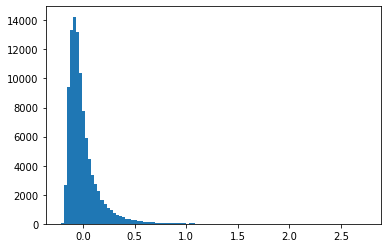

In [13]:
plt.hist(y, bins=100)
# plt.xlim(0, 0.5)

In [96]:
from tqdm.notebook import tqdm

In [97]:
y_preds = np.vstack([model.predict(x[i*64:(i+1)*64]) for i in tqdm(range(1563))]).flatten()

  0%|          | 0/1563 [00:00<?, ?it/s]

In [100]:
y.shape

(100000,)

In [102]:
y_preds = y_preds.flatten()

In [ ]:
plt.hist(y_preds.flatten(), bins=np.linspace(0, 1, 11), alpha=0.3)
plt.hist(y, bins=np.linspace(0, 1, 11), alpha=0.3)
plt.xlim(0, 1)

In [47]:
model.predict(x[[10, 20, 234, 763, 1237, 54736, 23452]])

array([[ 0.0021341 ],
       [-0.00667965],
       [ 0.02643603],
       [ 0.02145423],
       [-0.00443289],
       [ 0.0123741 ],
       [ 0.00979923]], dtype=float32)

In [48]:
y[[10, 20, 234, 763, 1237, 54736, 23452]]

array([-0.11560748, -0.05125648,  0.00429352, -0.00680148, -0.13017948,
       -0.05310948, -0.09022548])

In [24]:
model.save("./mape_loss_3")

2022-04-17 15:28:10.585568: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./mape_loss_3/assets


In [25]:
# modell = tf.keras.models.load_model("./initial_model_2")
modell = tf.keras.models.load_model("./mape_loss_2")

In [26]:
opt_test = pd.read_csv("../csv/options/raw/2017-18options.csv")


KeyboardInterrupt



In [ ]:
x_test, y_test = setup_options_input(opt_test, 200000)

In [22]:
modell.evaluate(x_test, y_test)

6250/6250 [==============================] - 103s 16ms/step - loss: 39.2194 - mean_absolute_percentage_error: 39.2194 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1707


[39.219417572021484,
 39.219417572021484,
 0.26837822794914246,
 0.17069818079471588]

In [15]:
modell.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1979)              3918420   
                                                                 
 dense_17 (Dense)            (None, 3958)              7836840   
                                                                 
 dense_18 (Dense)            (None, 3958)              15669722  
                                                                 
 dense_19 (Dense)            (None, 1979)              7834861   
                                                                 
 dense_20 (Dense)            (None, 1)                 1980      
                                                                 
Total params: 35,261,823
Trainable params: 35,261,823
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_predict = modell.predict(x_test)

In [ ]:
plt.plot(y_test - y_predict)